In [1]:
from google.colab import drive


FOLDERNAME = 'damaged_structures_detector/images'

drive.mount('/content/drive', force_remount=True)

# assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
# %cp -r $FOLDERNAME ../../
# %cd ../../
# %cd images/
# # !bash get_datasets.sh
# %cd ../../

Mounted at /content/drive
/content/drive/My Drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler, RandomSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageOps
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from sklearn.metrics import confusion_matrix

from __future__ import print_function 
from __future__ import division
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


Dataset Preparation

In [0]:
# Intended Input Image Size
height = 224
width = 224
channels = 3

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = None)

In [0]:
train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = None)

In [7]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 21158
    Root location: damaged_structures_detector/images/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Dataloaders Preparation

In [0]:
# Number of training examples
num_train = len(train_dataset)

# Number of Validation examples
num_val = len(val_dataset)

# Number of Test Examples
num_test = len(test_dataset)

# Batch Size for Training
BATCH_SIZE = 128


# Shuffle the Data with Random Samplers
train_indices = list(range(num_train))
np.random.shuffle(train_indices)

val_indices = list(range(num_val))
np.random.shuffle(val_indices)

test_indices = list(range(num_test))
np.random.shuffle(test_indices)

train_idx, val_idx, test_idx = train_indices, val_indices, test_indices

In [0]:
########## For a test run let's take a small subset of dataset
num_train = 100
num_val   = 100

train_idx = train_idx[0:num_train]
val_idx = val_idx[0:num_val]
########## Comment out to train and validate on FULL DATASET

In [0]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(val_idx)
test_sampler  = SubsetRandomSampler(test_idx)


loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler) ## shuffle = True if sampler does not work 

loader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)  ## shuffle = True

loader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)



dataloaders_dict = {}
dataloaders_dict.update( {'train' : loader_train} )
dataloaders_dict.update( {'val' : loader_val} )
dataloaders_dict.update( {'test' : loader_test} )

In [11]:
loader_val.dataset.classes

['destroyed', 'not_destroyed']

Initiate Tensorboard Summary writer

In [0]:
# # runs is the default directory to save log files
# writer = SummaryWriter("runs/CIFAR10")

# # get a batch of data
# examples = iter(loader_test)
# batch_of_data, target_labels = examples.next()

# # Plot a batch of data
# img_grid = torchvision.utils.make_grid(batch_of_data)
# writer.add_image('Cifar10 images', img_grid)

# # Visualize model
# writer.add_graph(model, batch_of_data)

# # make sure that outputs are flashed
# writer.close()


Decide Model type and a few other parameters

In [0]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

The Following Function takes the model name, input dimensions, number of classes, feature extraction or finetuning, and pretrained or not and initializes the model. I only assume that the input image will have a square shape and even number of pixels in each dimensions (can easily modify if input needs to be different).

In [0]:
def initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """                
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)
          model_ft = nn.Sequential(first_conv_layer, model_ft)
  

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))  
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))  
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))  
          model_ft.features= nn.Sequential(*first_conv_layer)
        

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))  
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)
          model_ft.AuxLogits = nn.Sequential(first_conv_layer, model_ft.AuxLogits)
          model_ft = nn.Sequential(first_conv_layer, model_ft)


    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

Initialize or load and move model to GPU and create or load optimizer

In [0]:
# Initialize the model for this run

model_ft, input_size = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)

# Print the parameters of the model we just instantiated
#for param in model_ft.parameters():
#  print(param.data)

Load the last saved checkpoint

In [0]:
CHECKPOINT_PATH = "damaged_structures_detector/checkpoints/checkpoint.pth"
loaded_checkpoint = torch.load(CHECKPOINT_PATH)

In [18]:
# Update Parameters of the model

model_ft.load_state_dict(loaded_checkpoint['model_state'])

# Check if load worked
#for param in model_ft.parameters():
#  print(param.data)

<All keys matched successfully>

In [49]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9,nesterov = True)

# Load optimizer parameters from checkpoint
#optimizer_ft.load_state_dict(loaded_checkpoint['optim_state'])

## If we want Adam optimizer
#optimizer_ft = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

## Adagrad
#optimizer_ft = optim.Adagrad(params_to_update, lr=0.01, lr_decay=0, weight_decay=0, eps=1e-10)

## RMSProp
#optimizer_ft = optim.RMSprop(params_to_update, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)

print(optimizer_ft)

Params to learn:
	 fc.weight
	 fc.bias
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)


In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_train, num_val, num_epochs=25, save_checkpoint=False, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

          ######## DEBUGGING POINT 1

                #print(labels.unique())
                #print(labels.size())
                #print(labels)
                # zero the parameter gradients

          ########

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
          ######### DEBUGGING POINT 2  

                    #print(inputs.shape)
                    #print(outputs)
                    # if phase == 'train':
                    # if epoch ==0:
                    # print(preds.unique())
                    # print(labels.data.unique())
                    #print(labels.data.size())
                    #print(labels.data)
                    #print(preds)
                    #print(inputs.type)
                    #print(inputs.shape)
                    #print(inputs[0])
                    # print(labels.data.mean())

          #################
          
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
              epoch_loss = running_loss / num_train
              epoch_acc = running_corrects.double() / num_train

            if phase == 'val':
              epoch_loss = running_loss / num_val
              epoch_acc = running_corrects.double() / num_val

            # Add it to tensorboard writer
            #writer.add_scalar('training loss', epoch_loss, epoch)
            #writer.add_scalar('accuracy on val set', epoch_acc, epoch)

            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
               
                if save_checkpoint:
                  checkpoint = {
                     "epoch" : epoch,
                     "model_state" : model_ft.state_dict(),
                     "optim_state" : optimizer_ft.state_dict(),
                     "val_loss" : epoch_loss,
                     "val_acc" : epoch_acc
                  }
                  CHECKPOINT_PATH = "damaged_structures_detector/checkpoints/checkpoint.pth"
                  torch.save(checkpoint, CHECKPOINT_PATH)

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (val_acc_history, val_loss_history, train_acc_history, train_loss_history)

Epoch 0/19
----------
train Loss: 0.6277 Acc: 0.8800
val Loss: 1.1534 Acc: 0.8900
Epoch 1/19
----------
train Loss: 0.6066 Acc: 0.8800
val Loss: 1.1308 Acc: 0.8900
Epoch 2/19
----------
train Loss: 0.5776 Acc: 0.8800
val Loss: 1.1033 Acc: 0.8800
Epoch 3/19
----------
train Loss: 0.5429 Acc: 0.8800
val Loss: 1.0726 Acc: 0.8900
Epoch 4/19
----------
train Loss: 0.5047 Acc: 0.9000
val Loss: 1.0400 Acc: 0.8900
Epoch 5/19
----------
train Loss: 0.4650 Acc: 0.9100
val Loss: 1.0066 Acc: 0.8900
Epoch 6/19
----------
train Loss: 0.4259 Acc: 0.9200
val Loss: 0.9734 Acc: 0.8800
Epoch 7/19
----------
train Loss: 0.3890 Acc: 0.9300
val Loss: 0.9412 Acc: 0.8800
Epoch 8/19
----------
train Loss: 0.3557 Acc: 0.9300
val Loss: 0.9104 Acc: 0.8800
Epoch 9/19
----------
train Loss: 0.3265 Acc: 0.9400
val Loss: 0.8818 Acc: 0.8800
Epoch 10/19
----------
train Loss: 0.3016 Acc: 0.9500
val Loss: 0.8558 Acc: 0.8800
Epoch 11/19
----------
train Loss: 0.2807 Acc: 0.9600
val Loss: 0.8329 Acc: 0.8800
Epoch 12/19
--

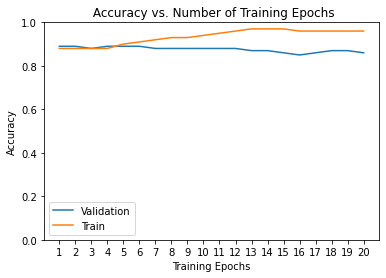

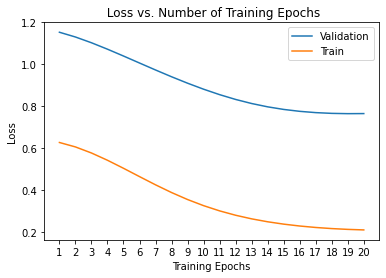

In [50]:
# Number of epochs to train for 
num_epochs = 20

save_checkpoint = False

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_train, num_val, num_epochs, save_checkpoint, is_inception=(model_name=="inception"))


# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method


plt.title(" Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),hist[0],label="Validation")
plt.plot(range(1,num_epochs+1),hist[2],label="Train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()


plt.title(" Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),hist[1],label="Validation")
plt.plot(range(1,num_epochs+1),hist[3],label="Train")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

BATCH size | Time per 10 epochs
128 | 16 mins


Visualize some model Predictions

In [0]:
model_test, input_size = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
model_test.load_state_dict(loaded_checkpoint['model_state'])
model_test.to(device)
model_test.eval()

test_transforms_print = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor()
                                     ])

test_transforms_predict = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                                     ])

In [0]:
def get_random_images(num):
    data = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = test_transforms_print)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

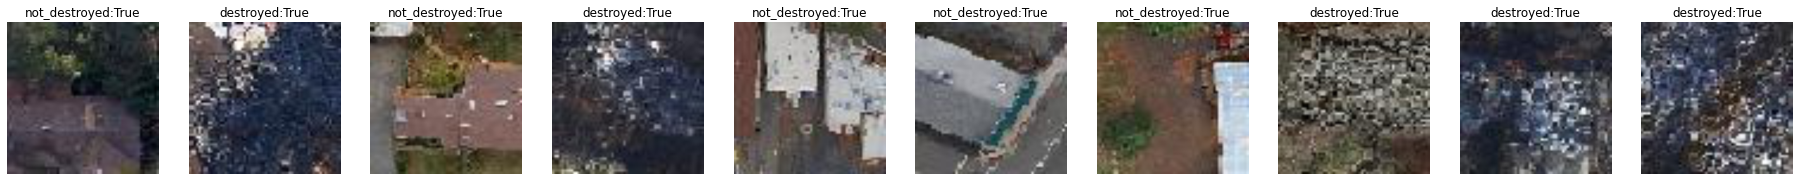

In [53]:
# Import Some Random Images
to_pil = transforms.ToPILImage()
images, labels = get_random_images(10)
fig=plt.figure(figsize=(32, 32))
classes = train_dataset.classes
gpu_images = images.clone()


for i in range(gpu_images.shape[0]):
    gpu_images[i,:,:,:] = test_transforms_predict(gpu_images[i,:,:,:])

gpu_images = gpu_images.to(device)

# Make predictions on them
outputs = model_test(gpu_images)
_, preds = torch.max(outputs, 1)
preds = preds.data.cpu().numpy()

labels = labels.cpu().numpy()


# Plot the results
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = preds[ii]
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

Confusion Matrix

Compute confusion matrix to evaluate the accuracy of a classification.

By definition a confusion matrix C is such that Ci,j is equal to the number of observations known to be in group i and predicted to be in group j.

Thus in binary classification, the count of true negatives is C0,0, false negatives is C1,0, true positives is C1,1 and false positives is C0,1.

In [0]:
conf_images, conf_labels = get_random_images(num_val)

for i in range(conf_images.shape[0]):
    conf_images[i,:,:,:] = test_transforms_predict(conf_images[i,:,:,:])

conf_images = conf_images.to(device)
outputs = model_ft(conf_images)
_, preds = torch.max(outputs, 1)
preds = preds.data.cpu().numpy()
conf_labels = conf_labels.numpy()

In [55]:
confusion_matrix(conf_labels, preds)

array([[57,  1],
       [ 7, 35]])

Save Model or Checkpoint

In [0]:
# FILE = "model_ft.pth"
# # torch.save(model_ft.state_dict(), FILE)

# checkpoint = {
#     "epoch" : num_epochs,
#     "model_state" : model_ft.state_dict(),
#     "optim_state" : optimizer_ft.state_dict()
# }
# CHECKPOINT_PATH = "damaged_structures_detector/checkpoints/checkpoint.pth"
# torch.save(checkpoint, CHECKPOINT_PATH)

Load Model (Needs initialization first)

In [0]:
# # loaded_model, input_size = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# # loaded_model.load_state_dict(torch.load(FILE))
# # loaded_model.eval()

# loaded_checkpoint = torch.load(CHECKPOINT_PATH)
# epoch = checkpoint["epoch"]
# model_state = checkpoint["model_state"]
# optim_state = checkpoint["optim_state"]

# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# optimizer_ft.load_state_dict(optim_state)

Save on GPU, Load on CPU

In [0]:
# device = torch.device("cuda")
# model.to(device)
# torch.save(model.state_dict(), FILE)

# device = torch.device('cpu')
# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE, map_location=device))

Save GPU, Load GPU

In [0]:
# device = torch.device("cuda")
# model.to(device)
# torch.save(model.state_dict(), FILE)

# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE))
# model.to(device)

Save CPU, Load GPU

In [0]:
# torch.save(model_ft.state_dict(), FILE)

# device = torch.device("cuda")
# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE, map_location="cuda:0"))
# model.to(device)